In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
#import dask.dataframe as dd
from xhistogram.xarray import histogram
from xmitgcm import llcreader
import geopandas as gpd

%matplotlib inline
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5356442.datarmor0/parcels-502090/libparcels_random_9d839db0-b2db-4bf6-b77e-13a2c6002bfd.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=3)

client = Client(cluster)

### Lagrangian spectra

In [3]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])

In [28]:
df_Lspectra_mean0 = p.load_diagnostic('spectra_raw_uv_mean0').persist()
df_Lspectra_mean1 = p.load_diagnostic('spectra_raw_uv_mean1').persist()
df_Lspectra_mean2 = p.load_diagnostic('spectra_raw_uv_mean2').persist()

### Eulerian spectra

In [4]:
sub = 4
ds_E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_nomean.zarr'))
ds_E = ds_E.isel(i=slice(0,None,sub),j=slice(0,None,sub))
ds_E = ds_E.where(ds_E.Depth>500, drop=False)
print(ds_E)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 270, j: 270)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 0 16 32 48 64 80 96 ... 4224 4240 4256 4272 4288 4304
  * j          (j) int64 0 16 32 48 64 80 96 ... 4224 4240 4256 4272 4288 4304
    mask       (face, j, i) bool dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<chunksize=(1, 12, 18, 1440), meta=np.ndarray>


In [ ]:
E = histogram(ds.lat4.rename('lat'), bins=[lat_bins], 
              weights=ds.SSUV, 
              dim=['i', 'j', 'face']
             )

E = (E/N).rename('E_SSUV').persist()

### Global spectra : 

In [5]:
dl = 1.
lon = np.arange(-180.,180., dl)
lat = np.arange(-70., 70., dl)

#### Lagrangian spectra binning

In [25]:
lat_L = df_Lspectra_mean0.lat.values.compute()

In [29]:
print(lat_L.size,np.unique(lat_E.flatten()).size)

660089 271112


In [45]:
np.unique(lat_E.flatten())[150000]

-73.99800872802734

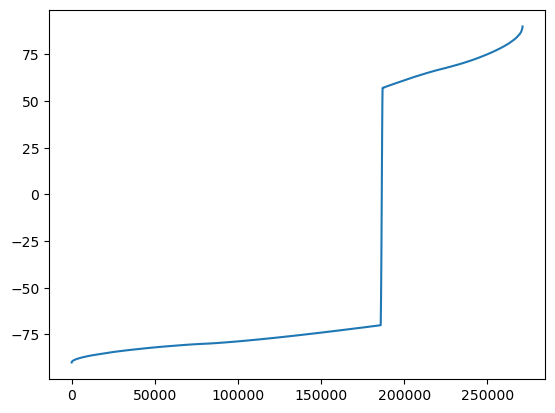

In [44]:
plt.plot(np.unique(lat_E.flatten()))

In [37]:
eps=0.05
np.where(lat_L<=np.unique(lat_E.flatten())[100000]+eps)

(array([], dtype=int64),)

In [22]:
df_Lspectra_mean0[:,
                  df_Lspectra_mean0.lat==np.unique(lat_E.flatten())]

ValueError: Metadata inference failed in `eq`.

Original error is below:
------------------------
ValueError('Lengths must match to compare', (2,), (271112,))

Traceback:
---------
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/utils.py", line 175, in raise_on_meta_error
    yield
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py", line 5172, in elemwise
    meta = partial_by_order(*parts, function=op, other=other)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/utils.py", line 1107, in partial_by_order
    return function(*args2, **kwargs)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/core/ops/common.py", line 65, in new_method
    return method(self, other)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/core/ops/__init__.py", line 370, in wrapper
    res_values = comparison_op(lvalues, rvalues, op)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/core/ops/array_ops.py", line 224, in comparison_op
    raise ValueError(


In [6]:
for ds_Lspectra in [df_Lspectra_mean0,df_Lspectra_mean1,df_Lspectra_mean2]:
    ds_Lspectra['lon'] = (ds_Lspectra['lon']+180)%360 - 180
    ds_Lspectra['lon_cut'] = ds_Lspectra['lon'].map_partitions(pd.cut, lon)
    ds_Lspectra['lat_cut'] = ds_Lspectra['lat'].map_partitions(pd.cut, lat)
    ds_Lspectra = ds_Lspectra.persist()

distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3820, in heartbeat_worker
    ws._executing = {
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3821, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: "('assign-91bc1485389ee15fc789bbe66a900728', 45)"


In [7]:
# Binning and averaging
uv_mean0 = df_Lspectra_mean0.groupby(['lat_cut']).mean().compute()
uv_mean1 = df_Lspectra_mean1.groupby(['lat_cut']).mean().compute()
uv_mean2 = df_Lspectra_mean2.groupby(['lat_cut']).mean().compute()

In [60]:
_ds = pd.melt(uv_mean0.set_index(uv_mean0.index.map(lambda v: v.mid)).drop(columns=['time','lon','lat']).reset_index()
         ,id_vars=['lat_cut'],var_name='frequency')

_ds['frequency'] = _ds['frequency'].astype('float64')

ds = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv'}
               ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()

In [61]:
_ds = pd.melt(uv_mean1.set_index(uv_mean1.index.map(lambda v: v.mid)).drop(columns=['time','lon','lat']).reset_index()
         ,id_vars=['lat_cut'],var_name='frequency')

_ds['frequency'] = _ds['frequency'].astype('float64')

ds['uv_mean1'] = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv_mean1'}
                           ).to_xarray().set_index(index=['lat_bins','frequency']).unstack().uv_mean1

In [62]:
_ds = pd.melt(uv_mean2.set_index(uv_mean2.index.map(lambda v: v.mid)).drop(columns=['time','lon','lat']).reset_index()
         ,id_vars=['lat_cut'],var_name='frequency')

_ds['frequency'] = _ds['frequency'].astype('float64')

ds['uv_mean2'] = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv_mean2'}
                           ).to_xarray().set_index(index=['lat_bins','frequency']).unstack().uv_mean2

#### Eulerian spectra binning

In [20]:
ds_E['lat_t'] = 0*ds_E.face+ds_E.YC
ds_E['lat4'] = 0*ds_E.SSUV+ds_E.YC
ds_E = ds_E.persist()

In [30]:
tst = xr.Dataset({'lat':ds_E.lat_t})

In [28]:
grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
ds_E = xr.merge([ds_E,grid])

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/array/core.py:4311: PerformanceWarning: Increasing number of chunks by factor of 13
  result = blockwise(
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/array/core.py:4311: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexin

In [35]:
ds_E

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 4320, i_g: 4320, j: 4320, j_g: 4320)
Coordinates: (12/22)
  * i          (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j          (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    ...         ...
  * i_g        (i_g) int64 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g        (j_g) int64 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
    rA         (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs        (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw        (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz        (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<chunksize=(1, 192, 288, 1440), meta=np.ndarray>
    lat        (face, j, i) float64 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    lat4       (face, j, i, freq_time) float64 dask.array<chunksize=(1, 192, 288, 1440), meta=np.ndarray>
    lat_t      (face, j, i) float64 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

In [46]:
lat_E = ds_E.lat4.values#.compute()

In [50]:
lat_E = lat_E.flatten()

In [52]:
lat_E = np.unique(lat_E)

In [54]:
lat_E

array([-78.38712311, -78.36917877, -78.28224945, ...,          nan,
                nan,          nan])

In [57]:
eps=0.1
np.where(np.logical_and(lat_L>=lat_E[0]-eps,lat_L<=lat_E[0]+eps))

(array([453451]),)

In [10]:
N = histogram(ds_E.lat, bins=[lat], 
              dim=['i', 'j', 'face']
             ).persist()

In [7]:
E = histogram(ds_E.lat4.rename('lat'), bins=[lat], 
              weights=ds_E.SSUV, 
              dim=['i', 'j', 'face']
             )

E = (E/N).rename('E_SSUV').persist()

In [11]:
E_nomean = histogram(ds_E.lat4.rename('lat'), bins=[lat], 
              weights=ds_E.SSUV, 
              dim=['i', 'j', 'face']
             )

E_nomean = (E_nomean/N).rename('E_SSUV').persist()

#### Plot

In [63]:
ds = ds.sortby('frequency')

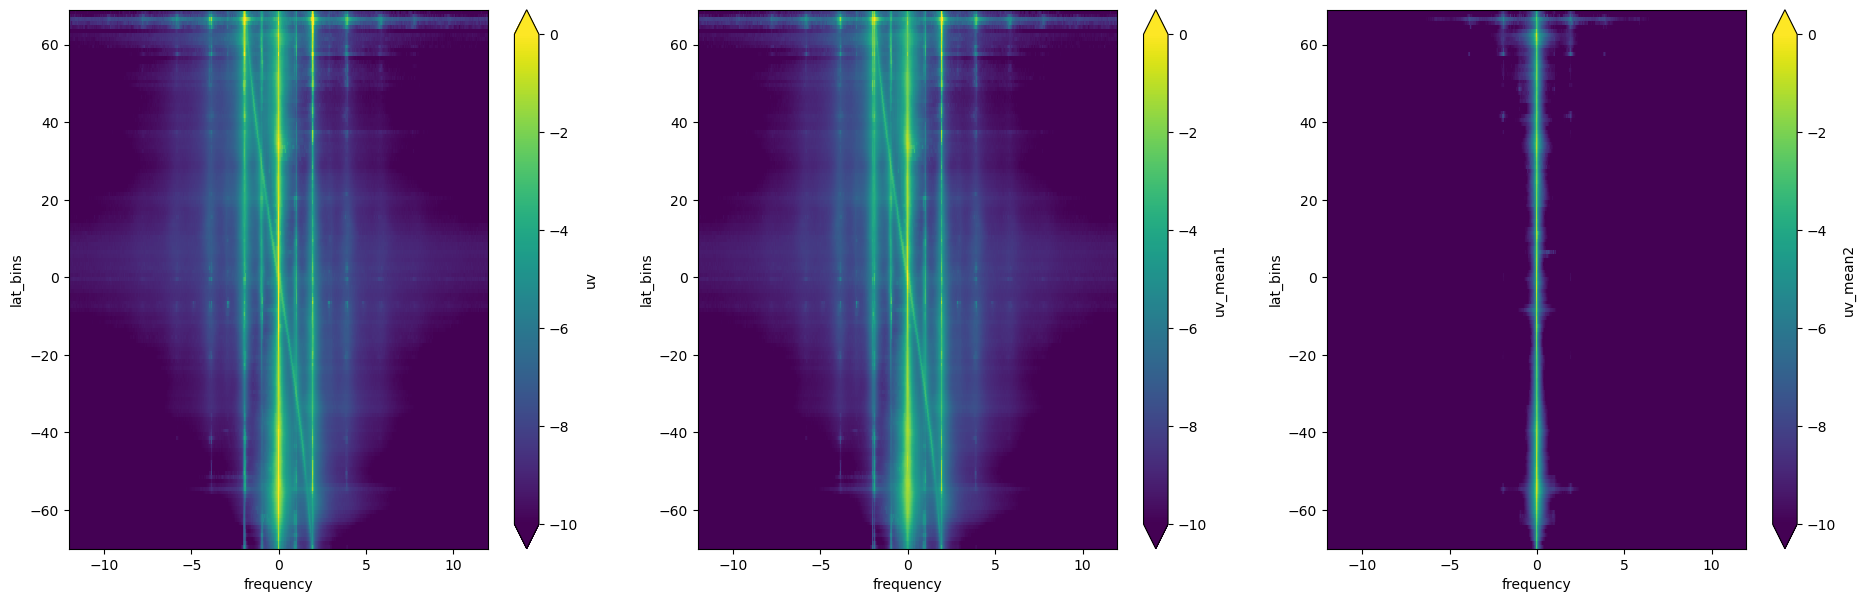

In [64]:
fig,axs = plt.subplots(1,3,figsize=(23,7))
for V,ax in zip(ds.keys(),axs):
    np.log(ds[V]).plot(ax=ax,cmap='viridis',vmax=0,vmin=-10)

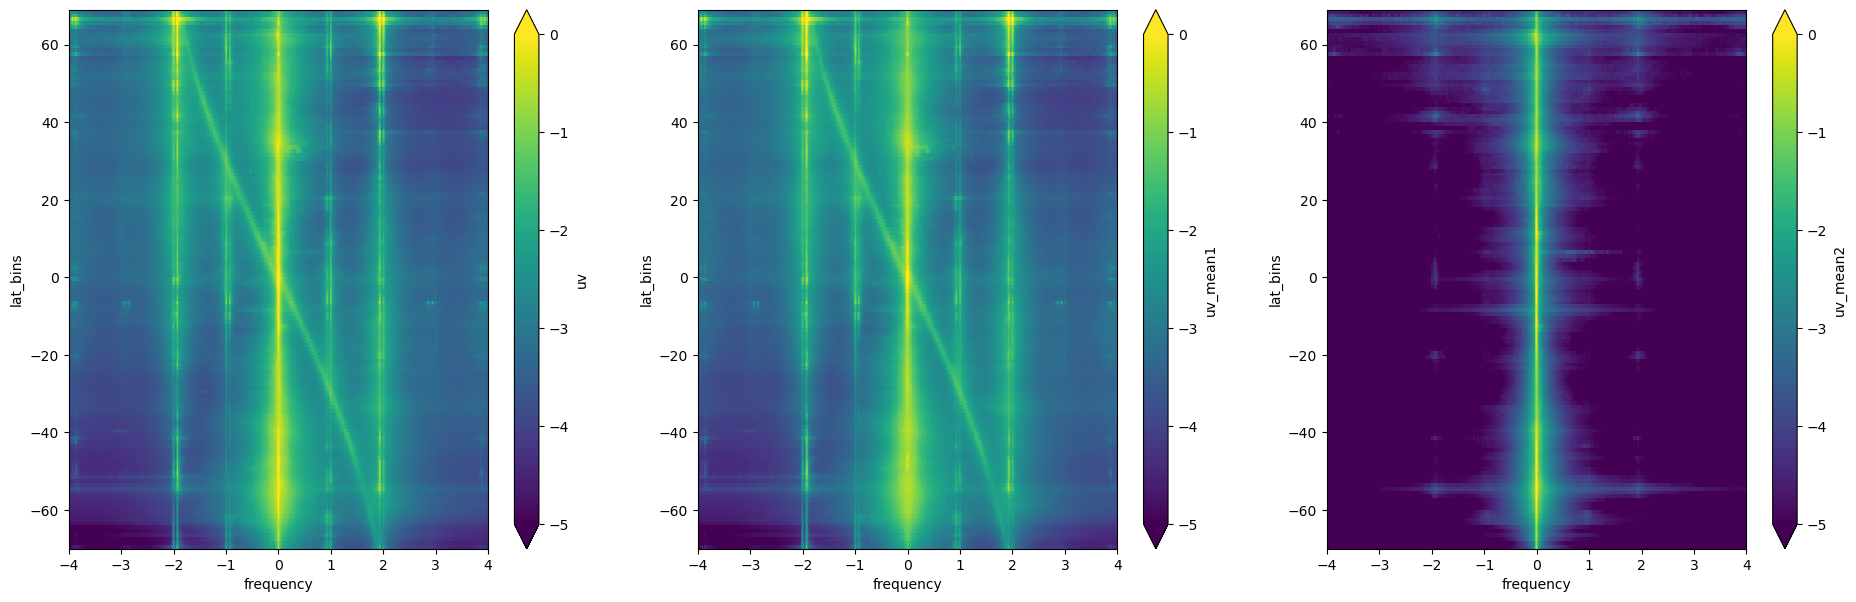

In [26]:
fig,axs = plt.subplots(1,3,figsize=(23,7))
for V,ax in zip(ds.keys(),axs):
    np.log10(ds[V]).plot(ax=ax,cmap='viridis',vmax=0,vmin=-5)
    ax.set_xlim(-4,4)

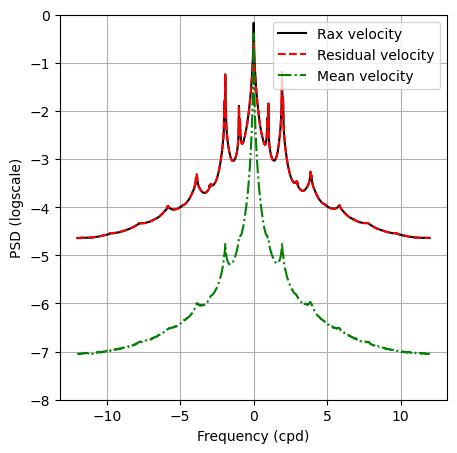

In [75]:
colors=['k','r','g']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,1,figsize=(5,5))
for V,c,style in zip(ds.keys(),colors,styles):
    np.log10(ds[V]).mean(['lat_bins']).plot(ax=ax,c=c,linestyle=style)
ax.grid();ax.set_ylim(-8,0);ax.set_ylabel('PSD (logscale)')
ax.set_xlabel('Frequency (cpd)');
ax.legend(labels)

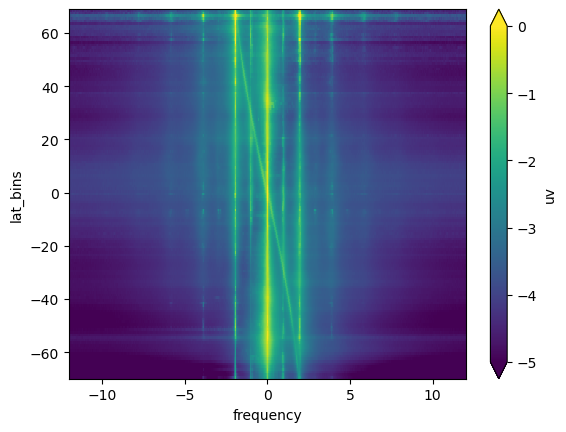

In [13]:
np.log10(ds['uv']).plot(cmap='viridis',vmax=0,vmin=-5)

(-4.0, 4.0)

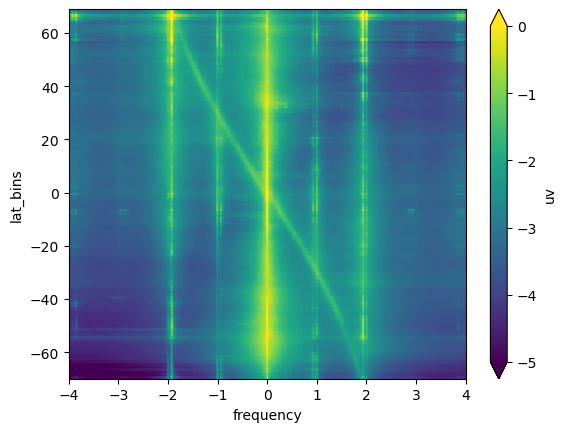

In [14]:
np.log10(ds['uv']).plot(cmap='viridis',vmax=0,vmin=-5)
plt.xlim(-4,4)

(-4.0, 4.0)

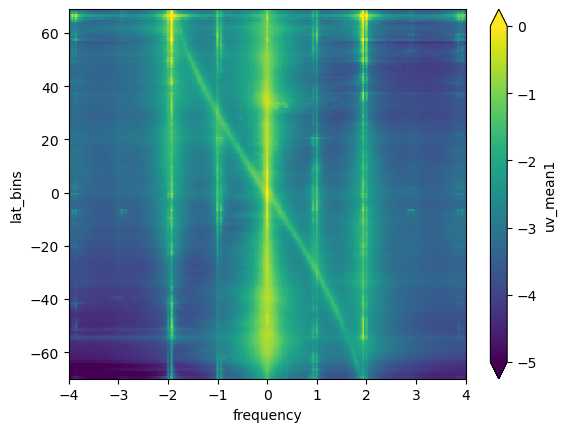

In [15]:
np.log10(ds['uv_mean1']).plot(cmap='viridis',vmax=0,vmin=-5)
plt.xlim(-4,4)

In [12]:
E = E.rename({'freq_time': 'frequency'})


In [13]:
E_nomean = E_nomean.rename({'freq_time': 'frequency'})

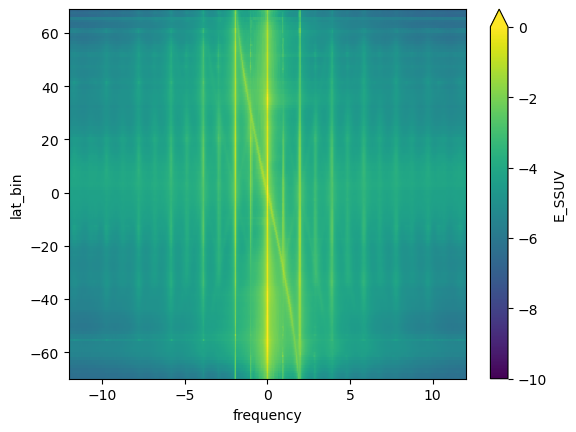

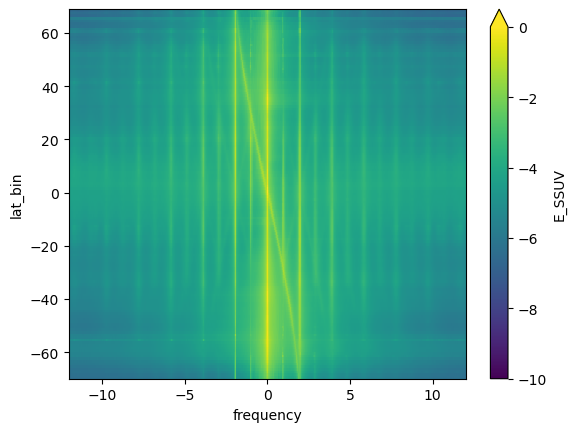

In [14]:
np.log10(E).plot(x='frequency', cmap='viridis', vmax=0,vmin=-10)
plt.figure()
np.log10(E_nomean).plot(x='frequency', cmap='viridis', vmax=0,vmin=-10)

(-4.0, 4.0)

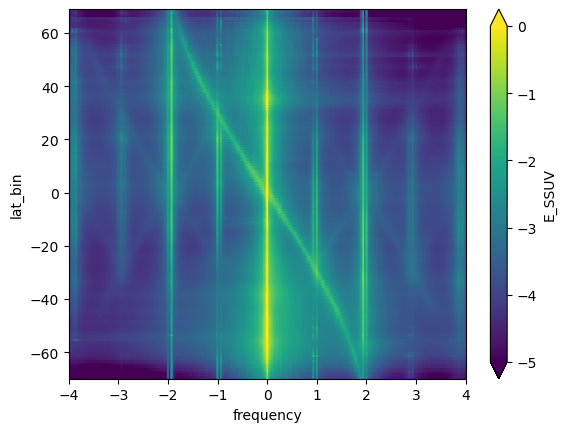

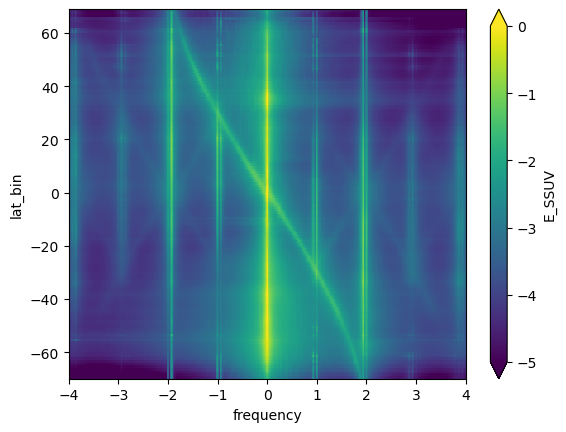

In [15]:
np.log10(E).plot(x='frequency', cmap='viridis', vmin=-5, vmax=0)
plt.xlim(-4,4)
plt.figure()
np.log10(E_nomean).plot(x='frequency', cmap='viridis', vmin=-5, vmax=0)
plt.xlim(-4,4)

In [29]:
ds

<xarray.Dataset>
Dimensions:    (frequency: 1440, lat_bins: 139)
Coordinates:
  * lat_bins   (lat_bins) float64 -69.5 -68.5 -67.5 -66.5 ... 66.5 67.5 68.5
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
Data variables:
    uv         (lat_bins, frequency) float64 1.313e-06 1.285e-06 ... 3.457e-05
    uv_mean1   (lat_bins, frequency) float64 1.325e-06 1.296e-06 ... 3.625e-05
    uv_mean2   (lat_bins, frequency) float64 1.168e-08 1.127e-08 ... 8.05e-07

In [36]:
E.rename({'lat_bin':'lat_bins'})-ds['uv']

<xarray.DataArray (frequency: 1440, lat_bins: 139)>
dask.array<sub, shape=(1440, 139), dtype=float64, chunksize=(1440, 139), chunktype=numpy.ndarray>
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins   (lat_bins) float64 -69.5 -68.5 -67.5 -66.5 ... 66.5 67.5 68.5

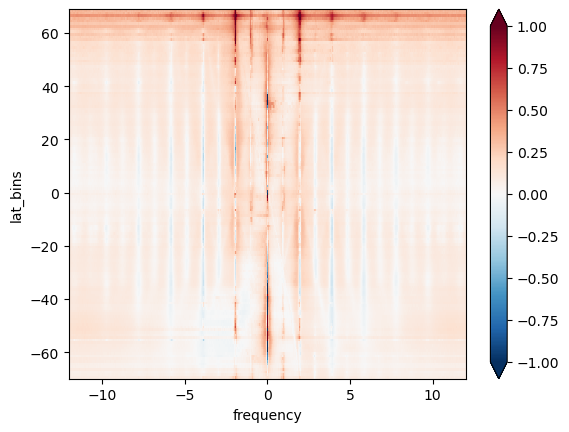

In [42]:
((np.log10(E.rename({'lat_bin':'lat_bins'}))-np.log10(ds['uv']))/np.log10(E.rename({'lat_bin':'lat_bins'}))).plot(x='frequency', cmap='RdBu_r',vmax=1)

### Sites of interest

In [29]:
def binned_spectra_site(bbox,df,dl):
    df_sub = df[np.logical_and(df.lat<bbox[3],df.lat>bbox[2]
                                               )].persist()

    df_sub = df[np.logical_and(df.lon<bbox[1],df.lon>bbox[0]
                                          )].persist()
    lon = np.arange(bbox[0],bbox[1], dl)
    lat = np.arange(bbox[-2], bbox[-1], dl)
    df_sub['lon'] = (df_sub['lon']+180)%360 - 180
    df_sub['lon_cut'] = df_sub['lon'].map_partitions(pd.cut, lon)
    df_sub['lat_cut'] = df_sub['lat'].map_partitions(pd.cut, lat)
    df_sub = df_sub.persist()
    uv_sub = df_sub.groupby(['lat_cut']).mean().compute()
    _ds = pd.melt(uv_sub.set_index(uv_sub.index.map(lambda v: v.mid)
                                  ).drop(columns=['time','lon','lat']
                                        ).reset_index(),id_vars=['lat_cut'],var_name='frequency')

    _ds['frequency'] = _ds['frequency'].astype('float64')
    ds_sub = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv'}
                   ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()
    return ds_sub

In [59]:
def binned_Espectra_site(bbox,ds,dl):
    ds['lat'] = 0*ds_E.face+ds.YC
    ds['lon'] = 0*ds_E.face+ds.XC
    ds['lat4'] = 0*ds_E.SSUV+ds.YC
    ds = ds.persist()
    ds_sub = ds.where(np.logical_and(ds.lat<=bbox[3],ds.lat>=bbox[2]),drop=True).persist()
    ds_sub = ds_sub.where(np.logical_and(ds_sub.lon<=bbox[1],ds_sub.lat>=bbox[0]),drop=True).persist()
    lat = np.arange(bbox[-2], bbox[-1], dl)
    N = histogram(ds_sub.lat, bins=[lat], 
              dim=['i', 'j', 'face']
             ).persist()
    E = histogram(ds_sub.lat4.rename('lat'), bins=[lat], 
              weights=ds_sub.SSUV, 
              dim=['i', 'j', 'face']
             )

    E = (E/N).rename('E_SSUV').persist()
    E = E.rename({'freq_time': 'frequency','lat_bin':'lat_bins'})
    return E

#### California : 

In [5]:
bbox = [-128, -123, 33, 38] # small bbox

In [6]:
dl = 1.

In [30]:
df_mean0_Cal = binned_spectra_site(bbox,df_Lspectra_mean0,dl);
df_mean1_Cal = binned_spectra_site(bbox,df_Lspectra_mean1,dl);
df_mean2_Cal = binned_spectra_site(bbox,df_Lspectra_mean2,dl);

In [31]:
ds_Cal = xr.merge([df_mean0_Cal,df_mean1_Cal.uv.rename('uv_mean1')
                   ,df_mean2_Cal.uv.rename('uv_mean2')])

In [23]:
dsE_Cal = binned_Espectra_site(bbox,ds_E,dl)

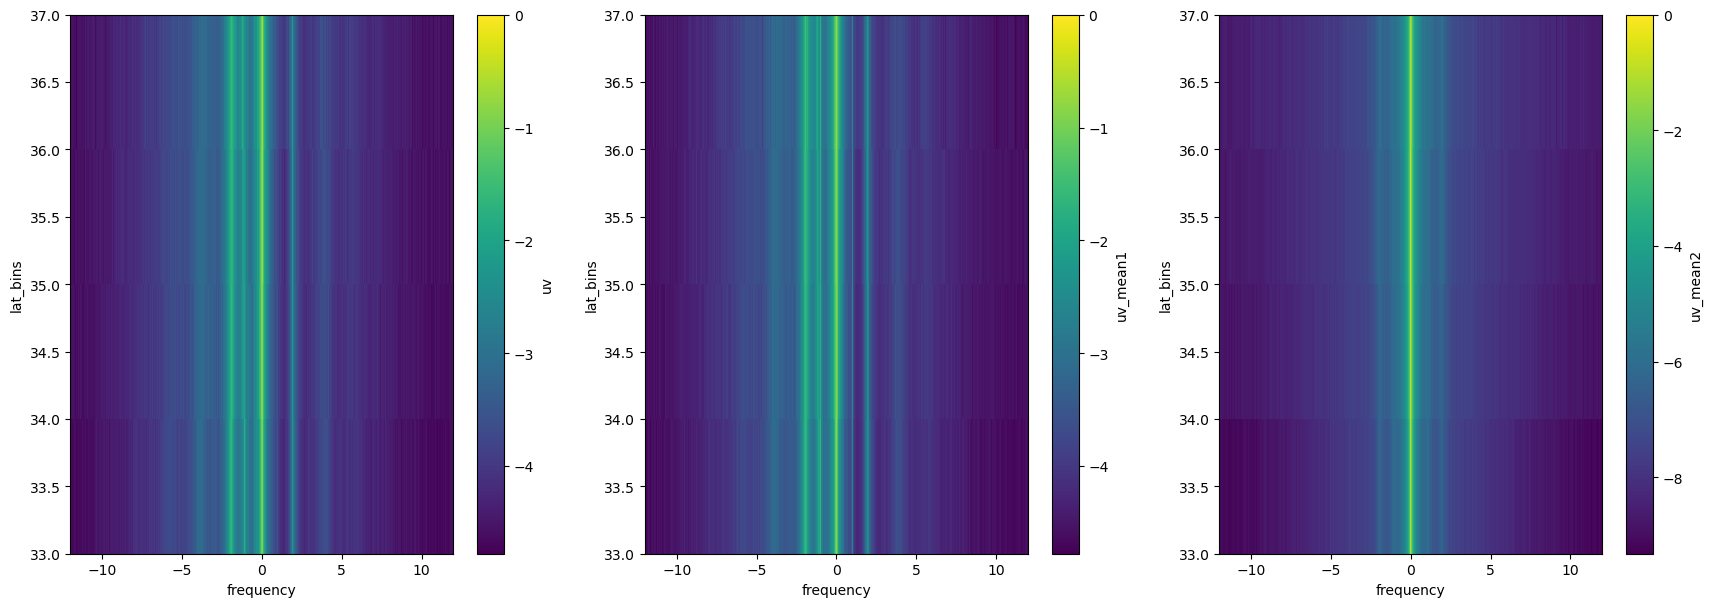

In [11]:
fig, axs = plt.subplots(1,len(ds_Cal.keys()),figsize=(len(ds_Cal.keys())*7,7))
for V,ax in zip(ds_Cal.keys(),axs):
    np.log10(ds_Cal[V]).plot(ax=ax,vmax=0)

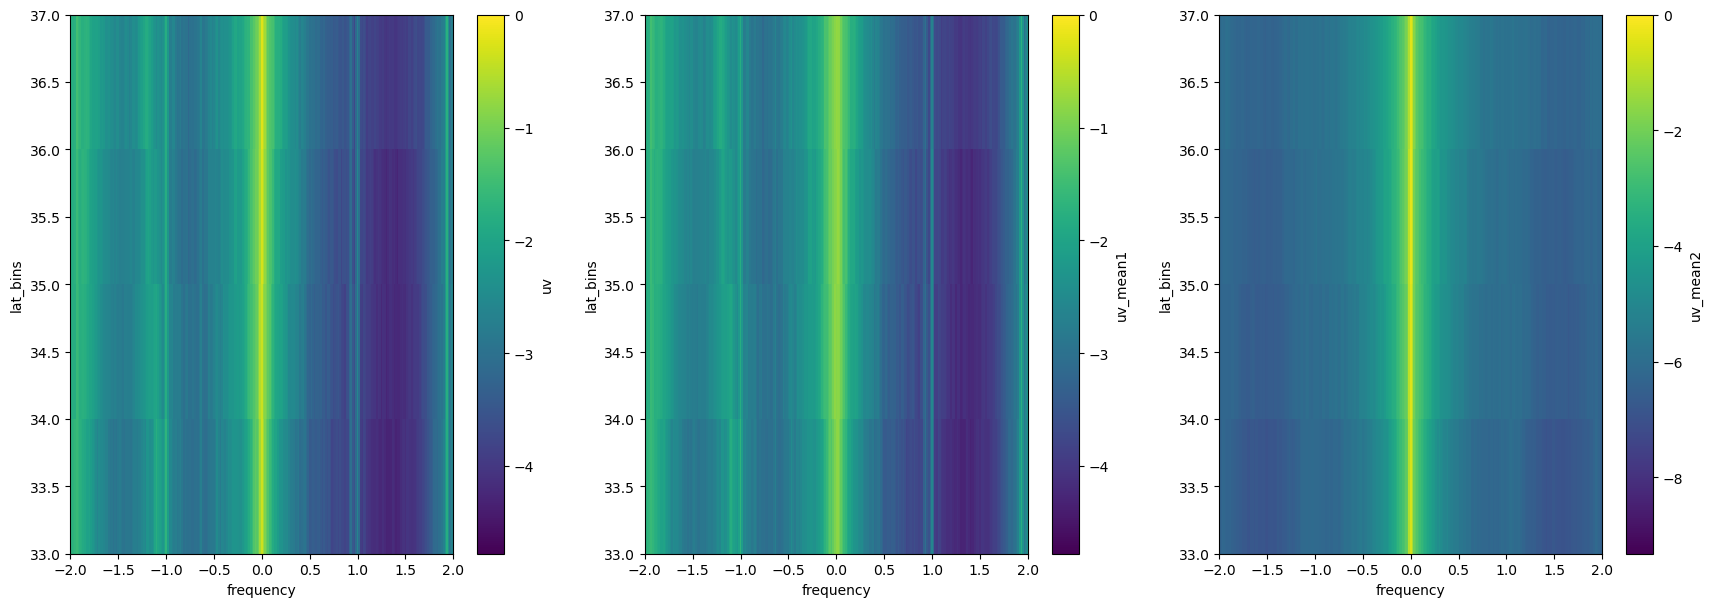

In [12]:
fig, axs = plt.subplots(1,len(ds_Cal.keys()),figsize=(len(ds_Cal.keys())*7,7))
for V,ax in zip(ds_Cal.keys(),axs):
    np.log10(ds_Cal[V]).plot(ax=ax,vmax=0)
    ax.set_xlim(-2,2)

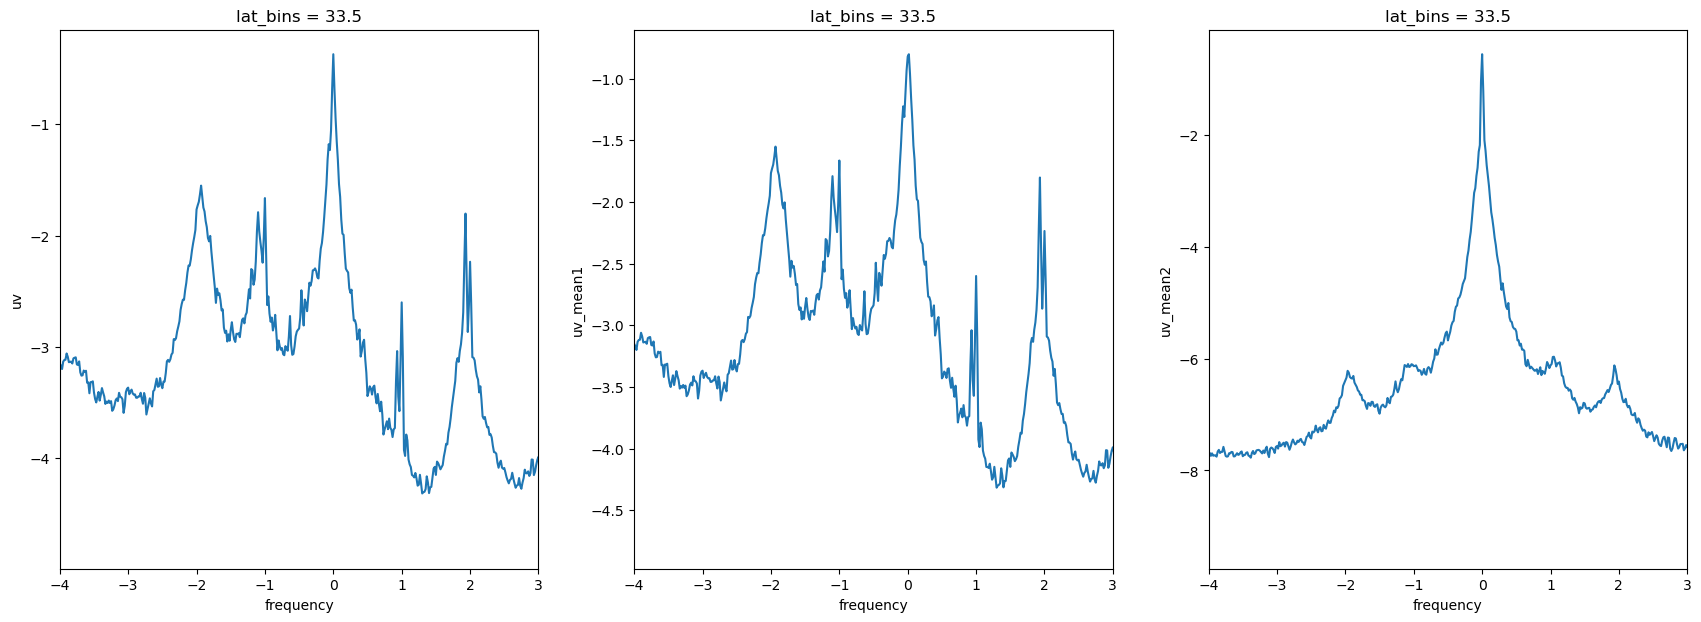

In [13]:
fig, axs = plt.subplots(1,len(ds_Cal.keys()),figsize=(len(ds_Cal.keys())*7,7))
for V,ax in zip(ds_Cal.keys(),axs):
    np.log10(ds_Cal[V]).isel(lat_bins=0).plot(ax=ax)
    ax.set_xlim(-4,3)

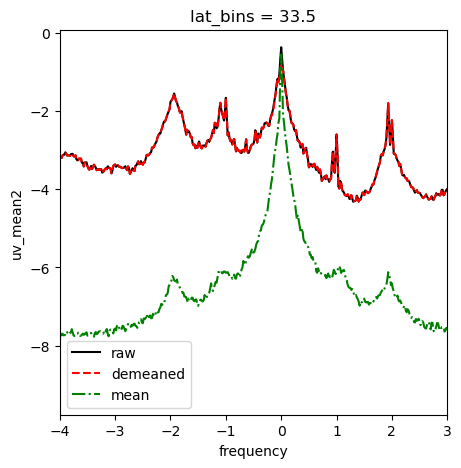

In [23]:
colors=['k','r','g']
styles=['-','--','-.']
fig, ax = plt.subplots(1,1,figsize=(5,5))
for V,c,style in zip(ds_Cal.keys(),colors,styles):
    np.log10(ds_Cal[V]).isel(lat_bins=0).plot(c=c,linestyle=style,ax=ax)
    ax.set_xlim(-4,3)
labels = ['raw', 'demeaned','mean']
ax.legend(labels)

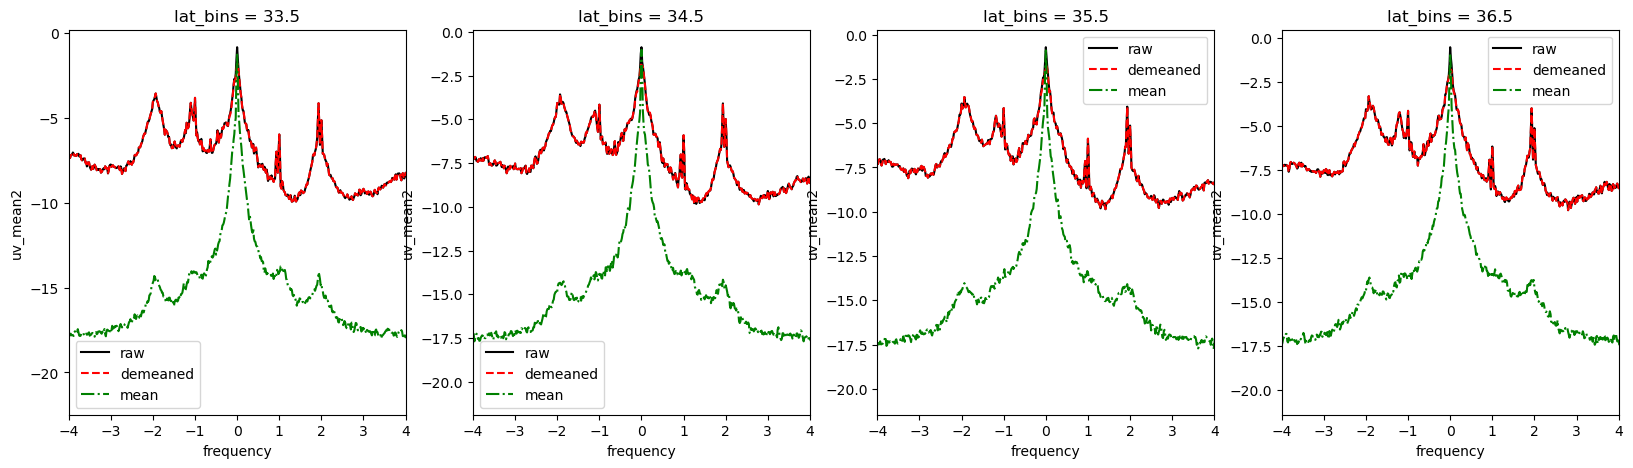

In [50]:
labels = ['raw', 'demeaned','mean']
fig,axs = plt.subplots(1,len(ds_Cal.lat_bins.values),figsize=(len(ds_Cal.lat_bins.values)*5,5))
for V,c,style in zip(ds_Cal.keys(),colors,styles):
    for i,ax in enumerate(axs):
    
        np.log(ds_Cal[V].isel(lat_bins=i)).plot(c=c,linestyle=style,ax=ax
                                           )
        ax.set_xlim(-4,4)
        ax.legend(labels)

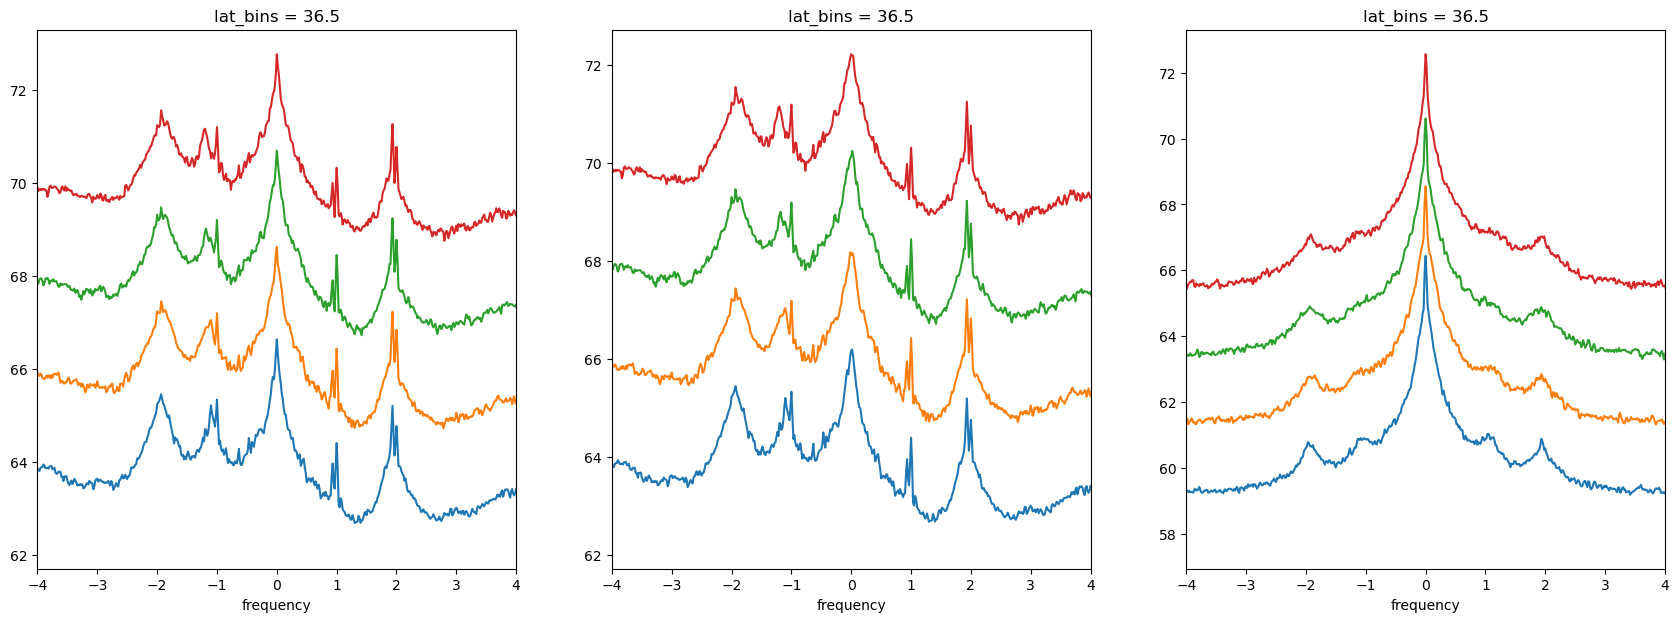

In [15]:
fig, axs = plt.subplots(1,len(ds_Cal.keys()),figsize=(len(ds_Cal.keys())*7,7))
for V,ax in zip(ds_Cal.keys(),axs):
    for i in ds_Cal.lat_bins:
        (np.log10(ds_Cal[V].sel(lat_bins=i))+2*i).plot(ax=ax)
        ax.set_xlim(-4,4)

(-5.0, 5.0)

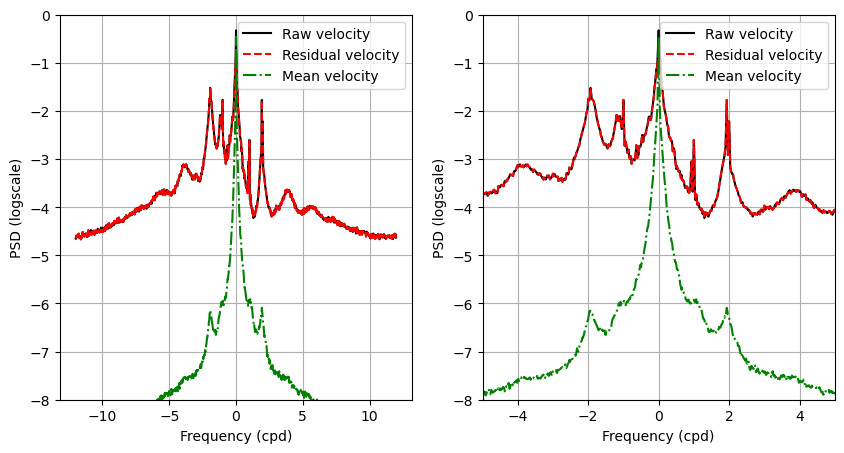

In [13]:
colors=['k','r','g']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
for V,c,style in zip(ds_Cal.keys(),colors,styles):
    np.log10(ds_Cal[V]).mean(['lat_bins']).plot(ax=ax[0],c=c,linestyle=style)
    np.log10(ds_Cal[V]).mean(['lat_bins']).plot(ax=ax[1],c=c,linestyle=style)
for a in ax:
    a.grid();a.set_ylim(-8,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)
ax[1].set_xlim(-5,5)

#### Plot Eulérien

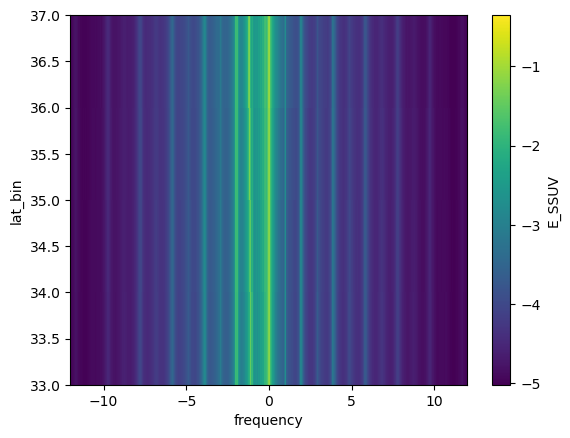

In [24]:
np.log10(dsE_Cal).plot(y='lat_bin')

(-5.0, 5.0)

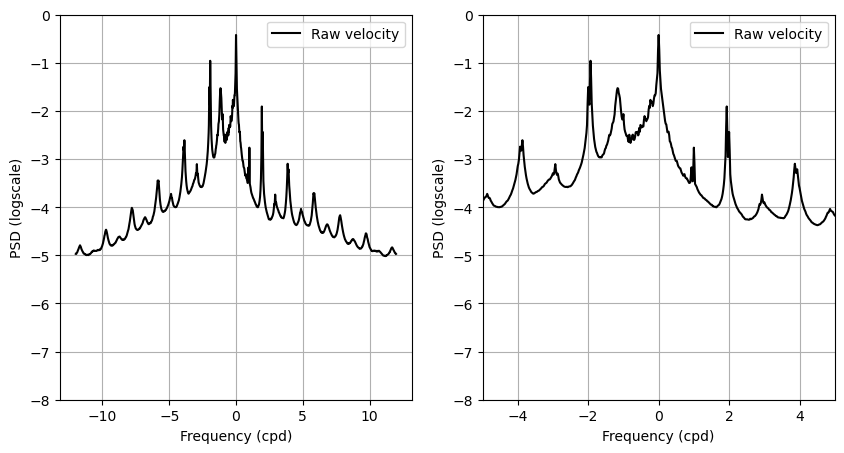

In [27]:
colors=['k','r','g']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
#for V,c,style in zip(dsE_Cal.keys(),colors,styles):
np.log10(dsE_Cal).mean(['lat_bin']).plot(ax=ax[0],c=colors[0],linestyle=styles[0])
np.log10(dsE_Cal).mean(['lat_bin']).plot(ax=ax[1],c=colors[0],linestyle=styles[0])
for a in ax:
    a.grid();a.set_ylim(-8,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)
ax[1].set_xlim(-5,5)

#### Comparison E/L

(-5.0, 5.0)

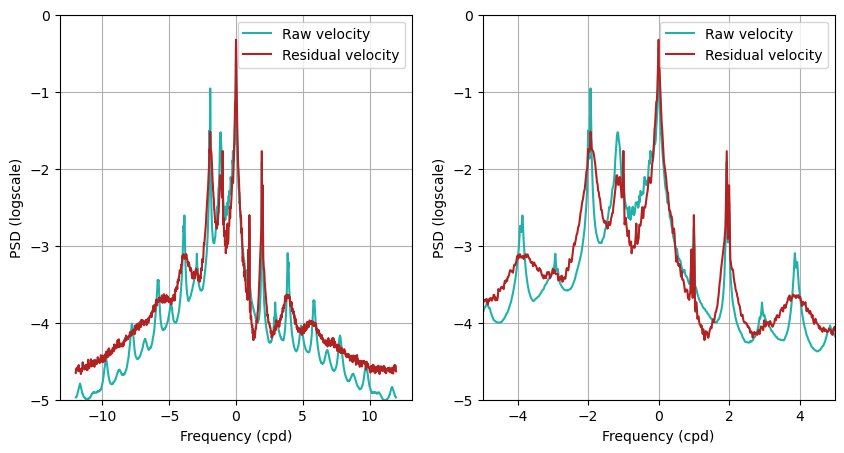

In [52]:
#colors=['k','r','g']
colors=['lightseagreen','firebrick']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
#for V,c,style in zip(dsE_Cal.keys(),colors,styles):
np.log10(dsE_Cal).mean(['lat_bins']).plot(ax=ax[0],c=colors[0],linestyle=styles[0])
np.log10(dsE_Cal).mean(['lat_bins']).plot(ax=ax[1],c=colors[0],linestyle=styles[0])
np.log10(ds_Cal['uv']).mean(['lat_bins']).plot(ax=ax[0],c=colors[1],linestyle=styles[0])
np.log10(ds_Cal['uv']).mean(['lat_bins']).plot(ax=ax[1],c=colors[1],linestyle=styles[0])
for a in ax:
    a.grid();a.set_ylim(-5,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)
ax[1].set_xlim(-5,5)

In [38]:
dsE_Cal = dsE_Cal.compute()

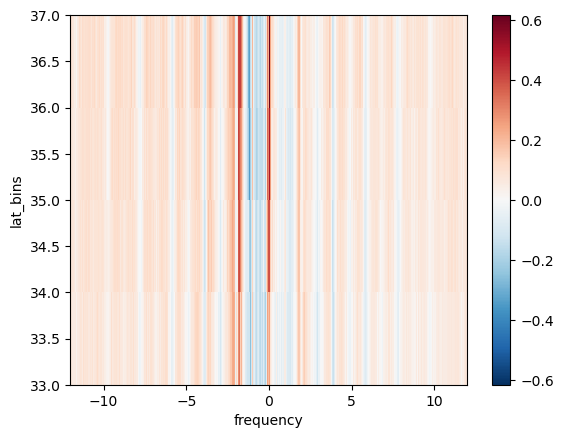

In [43]:
((np.log10(dsE_Cal)-np.log10(ds_Cal['uv']))/np.log10(ds_Cal['uv'])).plot(y='lat_bins',cmap='RdBu_r')

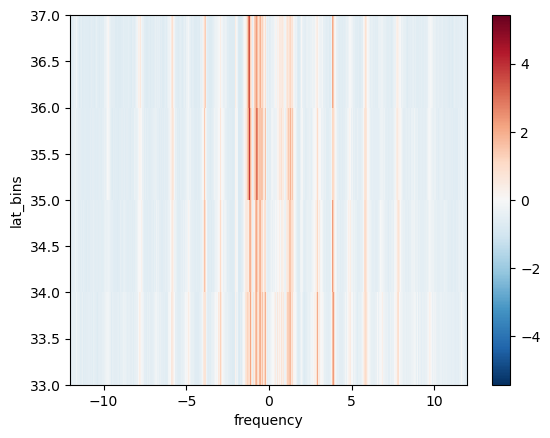

In [46]:
((dsE_Cal-ds_Cal['uv'])/ds_Cal['uv']).plot(y='lat_bins')

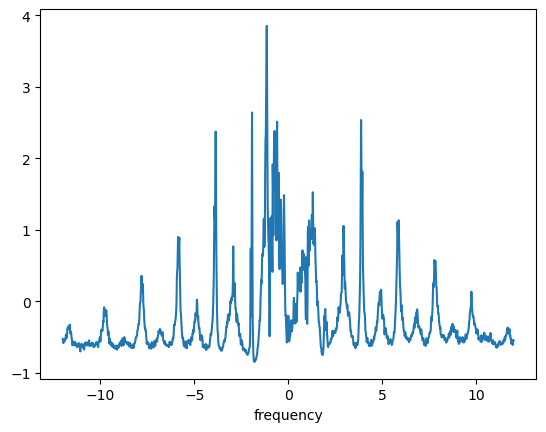

In [48]:
((dsE_Cal.mean('lat_bins')-ds_Cal['uv'].mean('lat_bins'))/ds_Cal['uv'].mean('lat_bins')).plot()

#### Mediterranean sea

In [53]:
bbox = [-2, 8, 36, 45] # large bbox


In [54]:
df_mean0_Med = binned_spectra_site(bbox,df_Lspectra_mean0,dl);
df_mean1_Med = binned_spectra_site(bbox,df_Lspectra_mean1,dl);
df_mean2_Med = binned_spectra_site(bbox,df_Lspectra_mean2,dl);

In [55]:
ds_Med = xr.merge([df_mean0_Med,df_mean1_Med.uv.rename('uv_mean1')
                   ,df_mean2_Med.uv.rename('uv_mean2')])

In [60]:
dsE_Med = binned_Espectra_site(bbox,ds_E,dl)

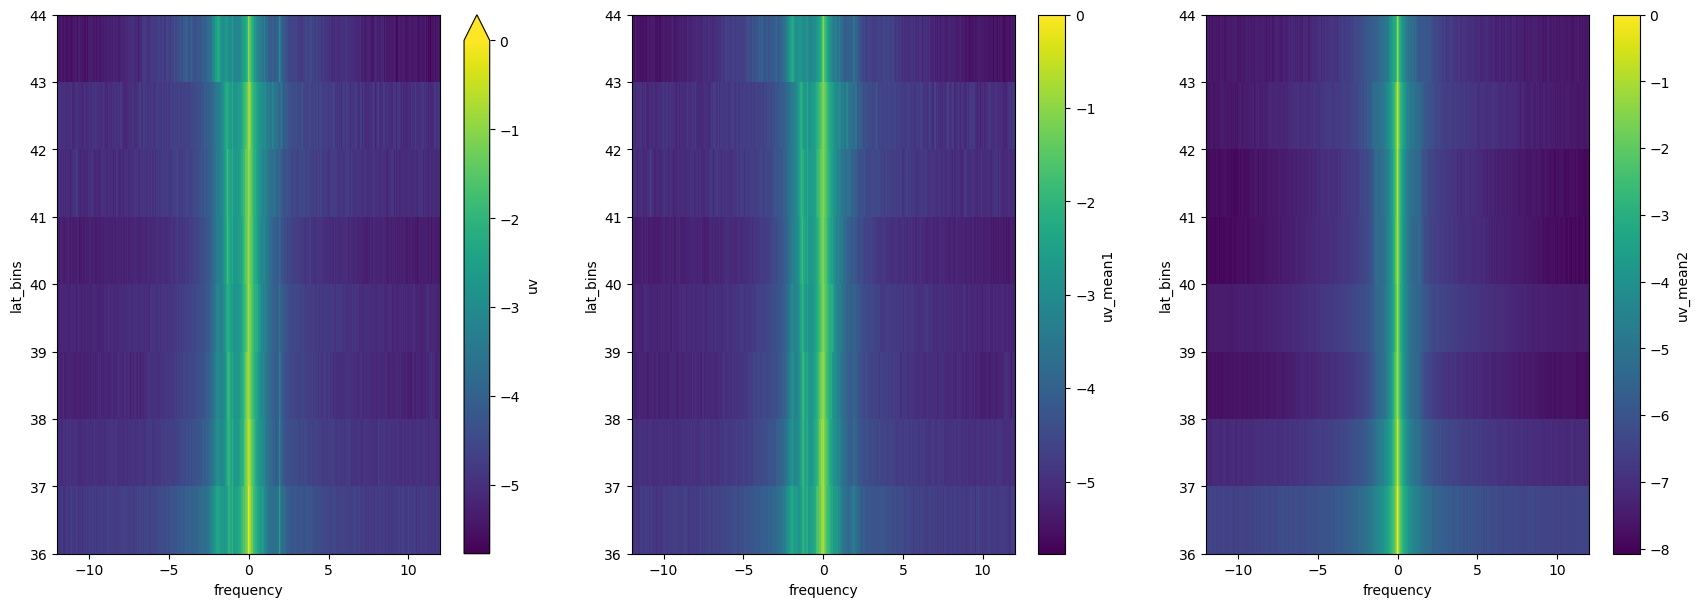

In [55]:
fig, axs = plt.subplots(1,len(ds_Med.keys()),figsize=(len(ds_Med.keys())*7,7))
for V,ax in zip(ds_Med.keys(),axs):
    np.log10(ds_Med[V]).plot(ax=ax,cmap='viridis',vmax=0)

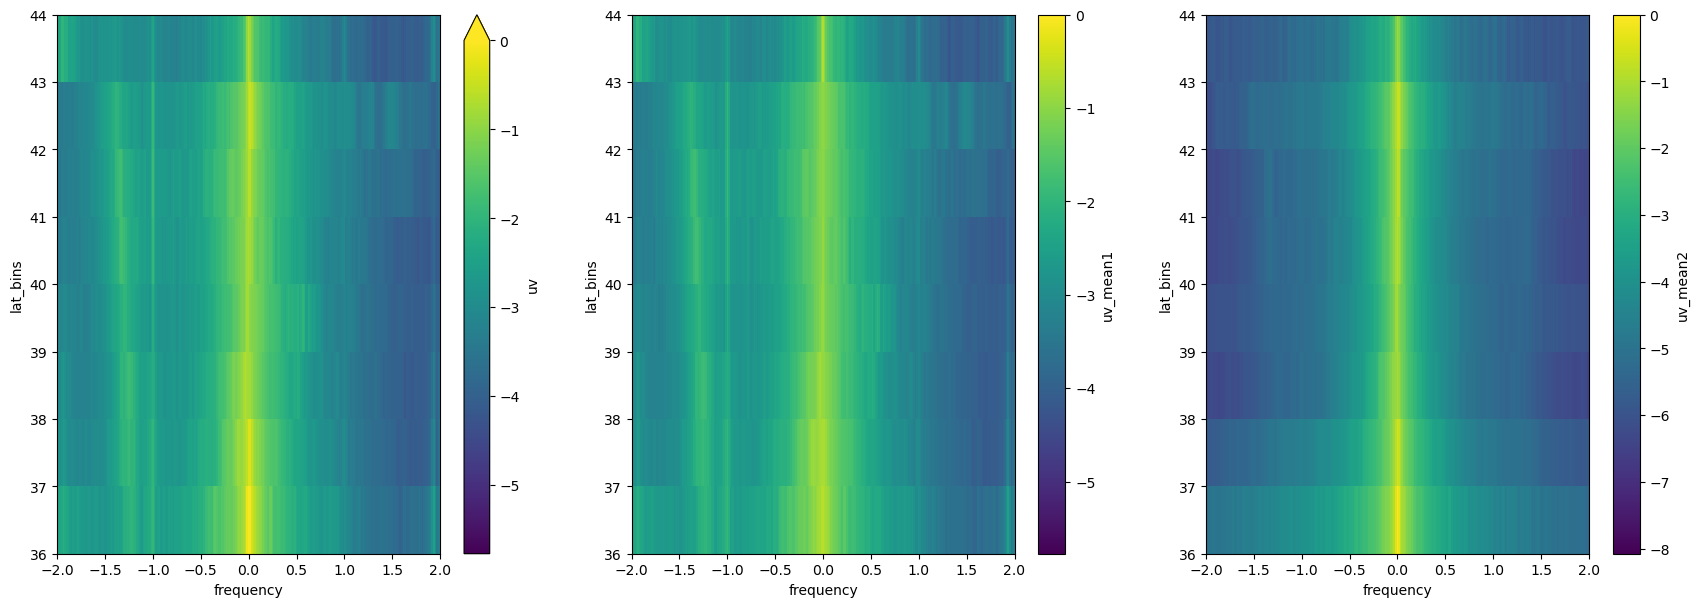

In [56]:
fig, axs = plt.subplots(1,len(ds_Med.keys()),figsize=(len(ds_Med.keys())*7,7))
for V,ax in zip(ds_Med.keys(),axs):
    np.log10(ds_Med[V]).plot(ax=ax,cmap='viridis',vmax=0)
    ax.set_xlim(-2,2)

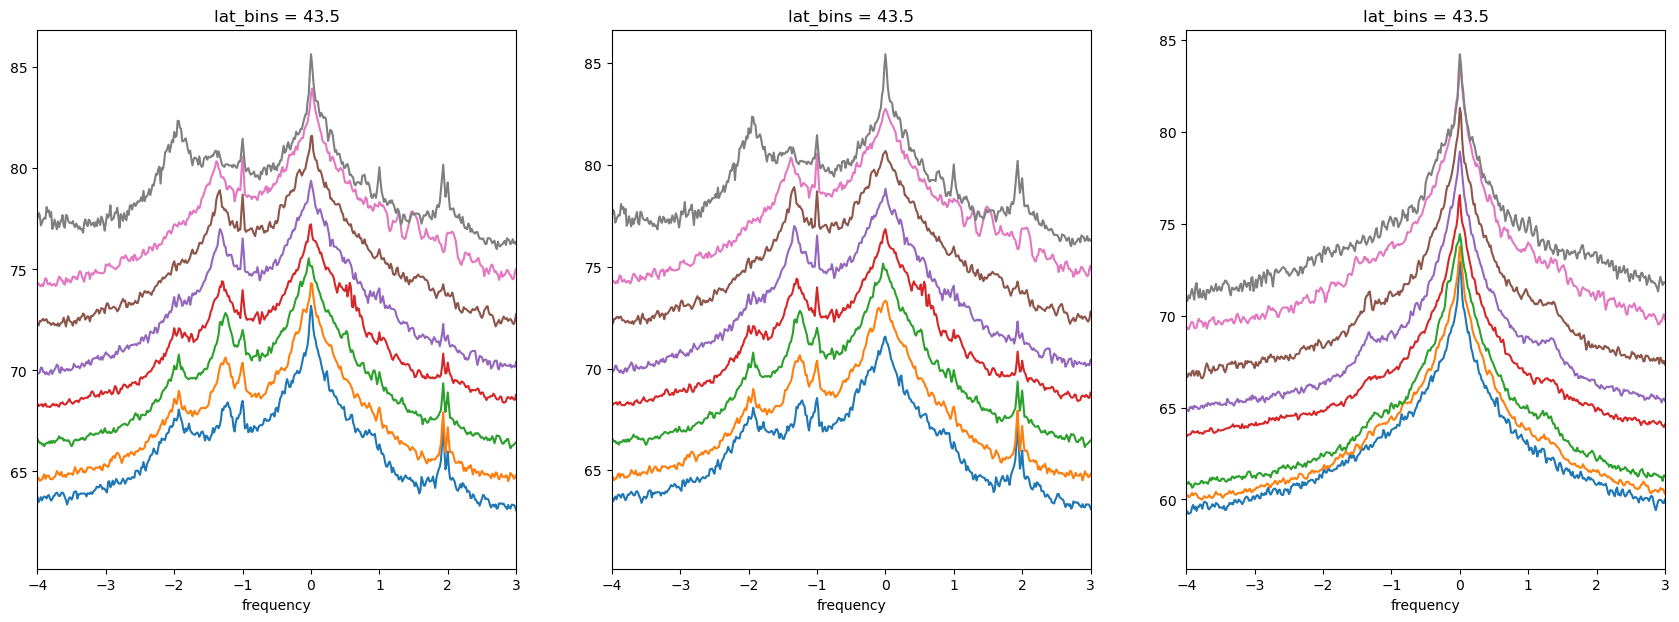

In [57]:
fig, axs = plt.subplots(1,len(ds_Med.keys()),figsize=(len(ds_Med.keys())*7,7))
for V,ax in zip(ds_Med.keys(),axs):
    for i in ds_Med.lat_bins:
        (np.log(ds_Med[V].sel(lat_bins=i))+2*i).plot(ax=ax)
        ax.set_xlim(-4,3)

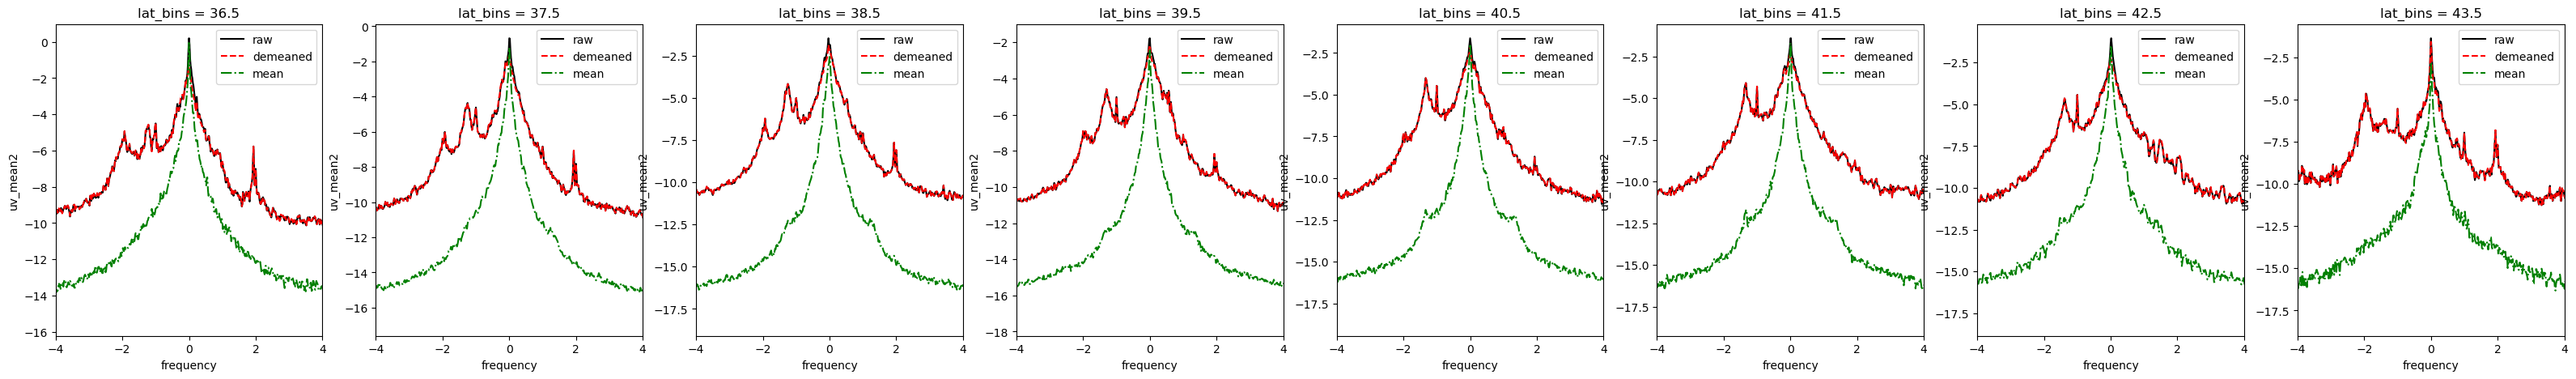

In [58]:
labels = ['raw', 'demeaned','mean']
fig,axs = plt.subplots(1,len(ds_Med.lat_bins.values),figsize=(len(ds_Med.lat_bins.values)*5,5))
for V,c,style in zip(ds_Med.keys(),colors,styles):
    for i,ax in enumerate(axs):
    
        np.log(ds_Med[V].isel(lat_bins=i)).plot(c=c,linestyle=style,ax=ax
                                           )
        ax.set_xlim(-4,4)
        ax.legend(labels)

(-5.0, 5.0)

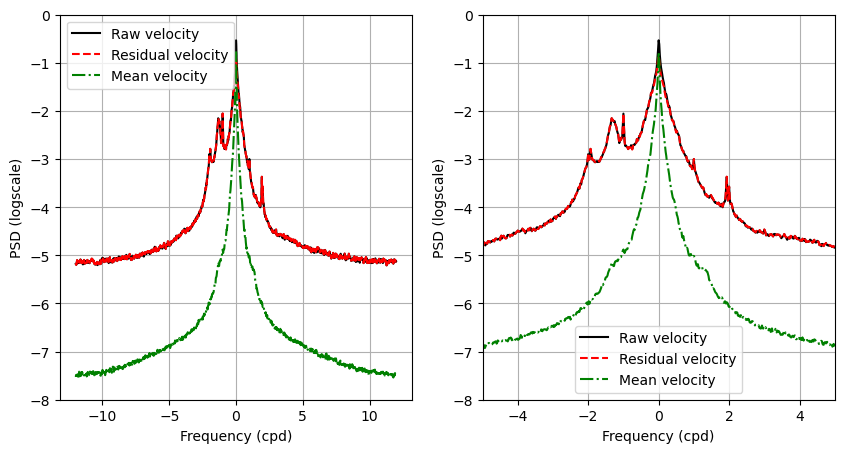

In [17]:
colors=['k','r','g']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
for V,c,style in zip(ds_Med.keys(),colors,styles):
    np.log10(ds_Med[V]).mean(['lat_bins']).plot(ax=ax[0],c=c,linestyle=style)
    np.log10(ds_Med[V]).mean(['lat_bins']).plot(ax=ax[1],c=c,linestyle=style)
for a in ax:
    a.grid();a.set_ylim(-8,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)
ax[1].set_xlim(-5,5)

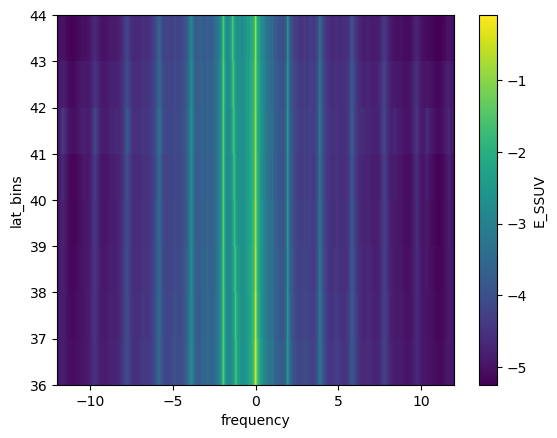

In [61]:
np.log10(dsE_Med).plot(y='lat_bins')

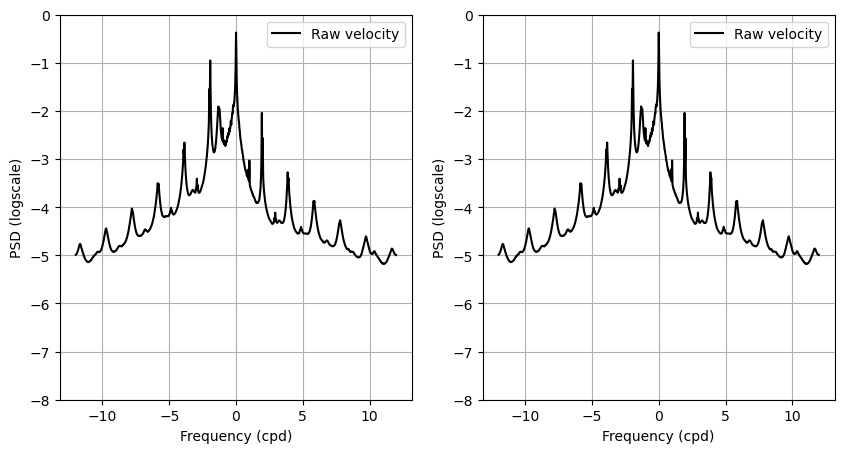

In [63]:
colors=['k','r','g']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
#for V,c,style in zip(dsE_Cal.keys(),colors,styles):
np.log10(dsE_Med).mean(['lat_bins']).plot(ax=ax[0],c=colors[0],linestyle=styles[0])
np.log10(dsE_Med).mean(['lat_bins']).plot(ax=ax[1],c=colors[0],linestyle=styles[0])
for a in ax:
    a.grid();a.set_ylim(-8,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)

(-5.0, 5.0)

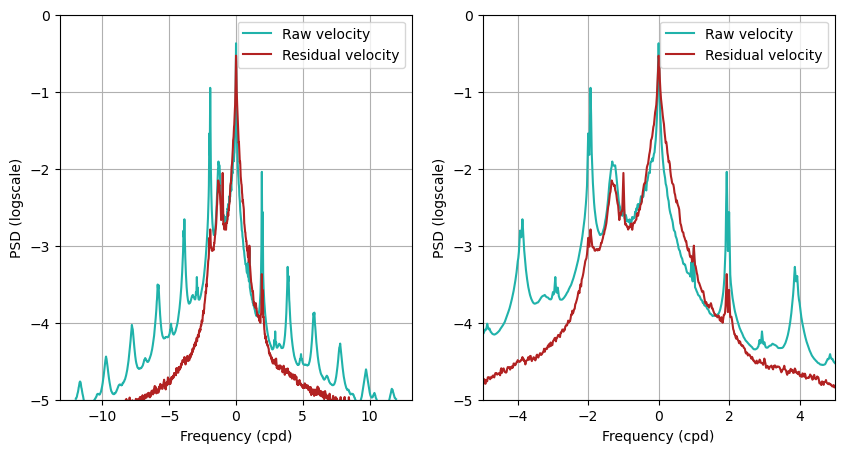

In [64]:
#colors=['k','r','g']
colors=['lightseagreen','firebrick']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
#for V,c,style in zip(dsE_Cal.keys(),colors,styles):
np.log10(dsE_Med).mean(['lat_bins']).plot(ax=ax[0],c=colors[0],linestyle=styles[0])
np.log10(dsE_Med).mean(['lat_bins']).plot(ax=ax[1],c=colors[0],linestyle=styles[0])
np.log10(ds_Med['uv']).mean(['lat_bins']).plot(ax=ax[0],c=colors[1],linestyle=styles[0])
np.log10(ds_Med['uv']).mean(['lat_bins']).plot(ax=ax[1],c=colors[1],linestyle=styles[0])
for a in ax:
    a.grid();a.set_ylim(-5,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)
ax[1].set_xlim(-5,5)

#### North west Australia

In [65]:
bbox = [120, 126, -20, -10]

In [66]:
df_mean0_NWA = binned_spectra_site(bbox,df_Lspectra_mean0,dl);
df_mean1_NWA = binned_spectra_site(bbox,df_Lspectra_mean1,dl);
df_mean2_NWA = binned_spectra_site(bbox,df_Lspectra_mean2,dl);

distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3820, in heartbeat_worker
    ws._executing = {
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3821, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: "('getitem-d6b9f2102c3b4ad4520effbb7a7a36ec', 25)"


In [67]:
ds_NWA = xr.merge([df_mean0_NWA,df_mean1_NWA.uv.rename('uv_mean1')
                   ,df_mean2_NWA.uv.rename('uv_mean2')])

In [68]:
dsE_NWA = binned_Espectra_site(bbox,ds_E,dl)

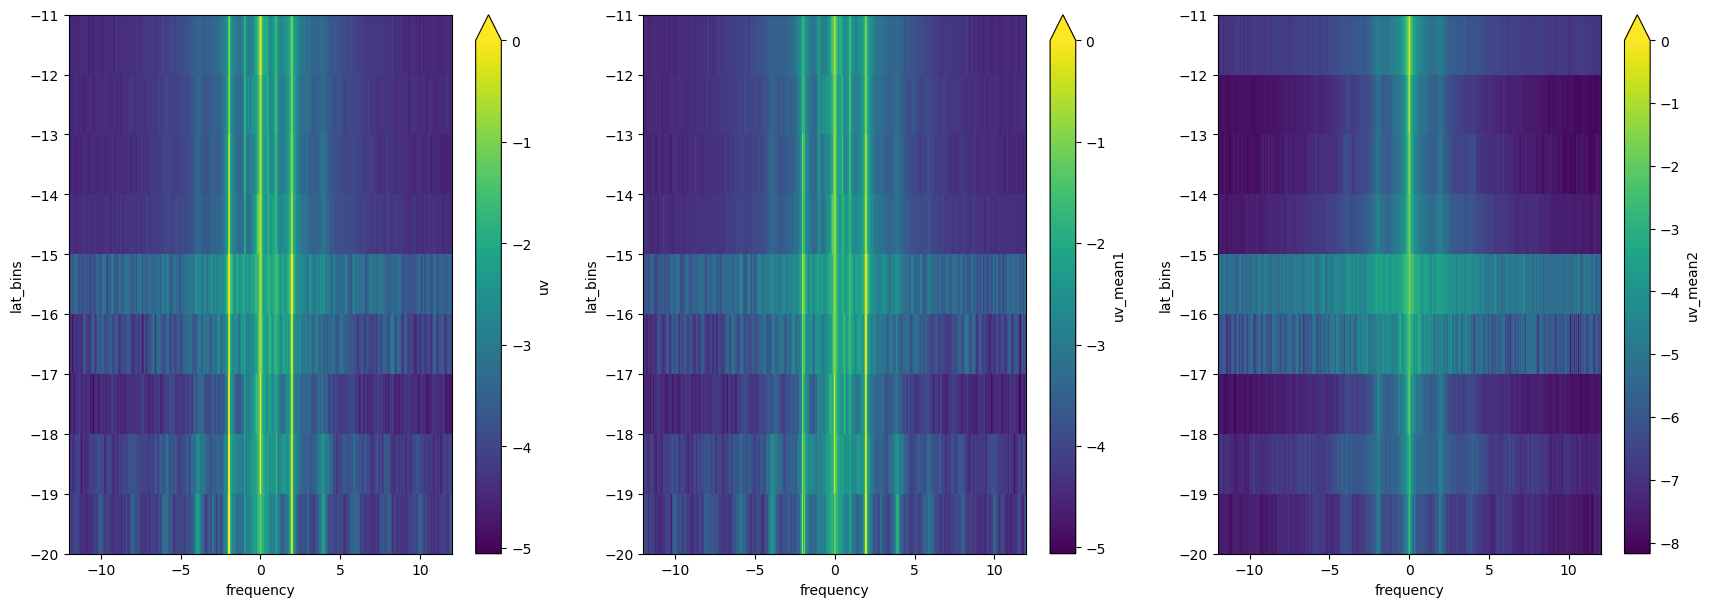

In [62]:
fig, axs = plt.subplots(1,len(ds_NWA.keys()),figsize=(len(ds_NWA.keys())*7,7))
for V,ax in zip(ds_NWA.keys(),axs):
    np.log10(ds_NWA[V]).plot(ax=ax,cmap='viridis',vmax=0)

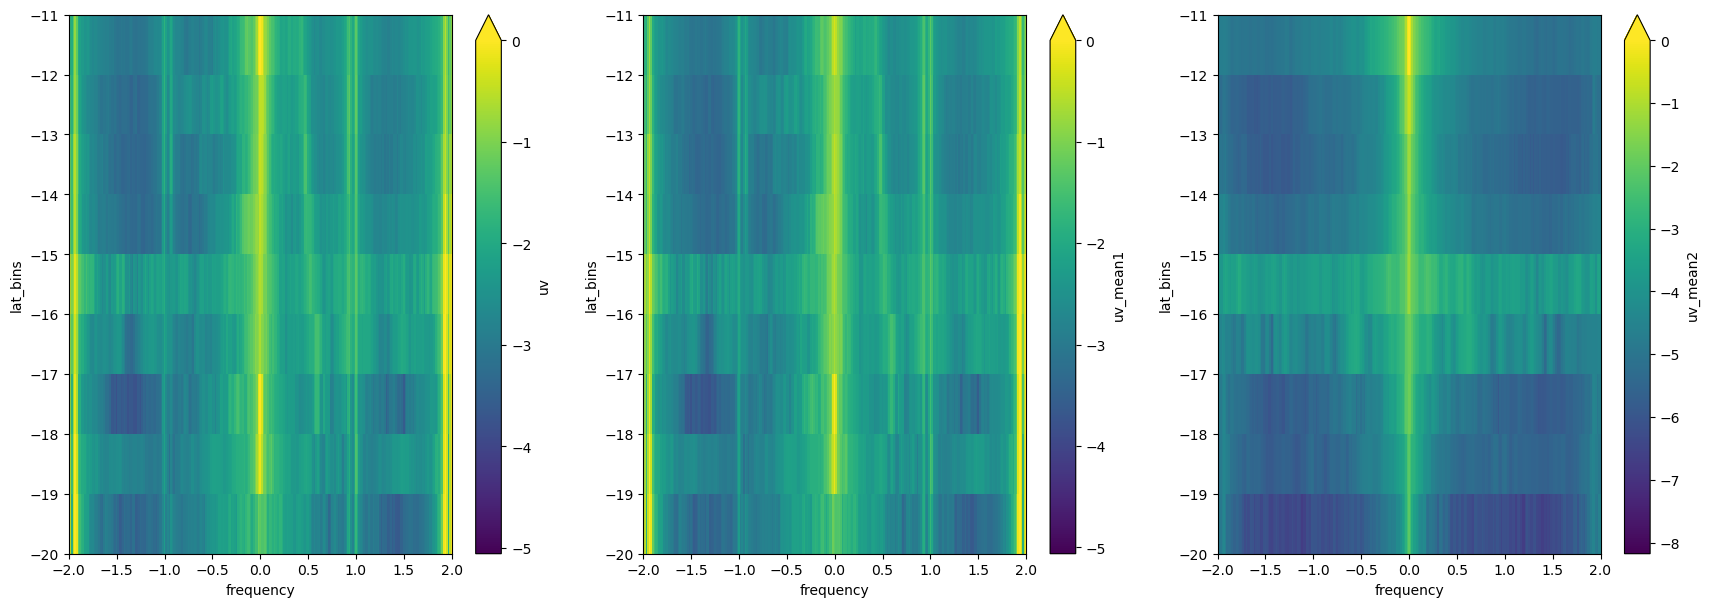

In [66]:
fig, axs = plt.subplots(1,len(ds_NWA.keys()),figsize=(len(ds_NWA.keys())*7,7))
for V,ax in zip(ds_NWA.keys(),axs):
    np.log10(ds_NWA[V]).plot(ax=ax,cmap='viridis',vmax=0)
    ax.set_xlim(-2,2)

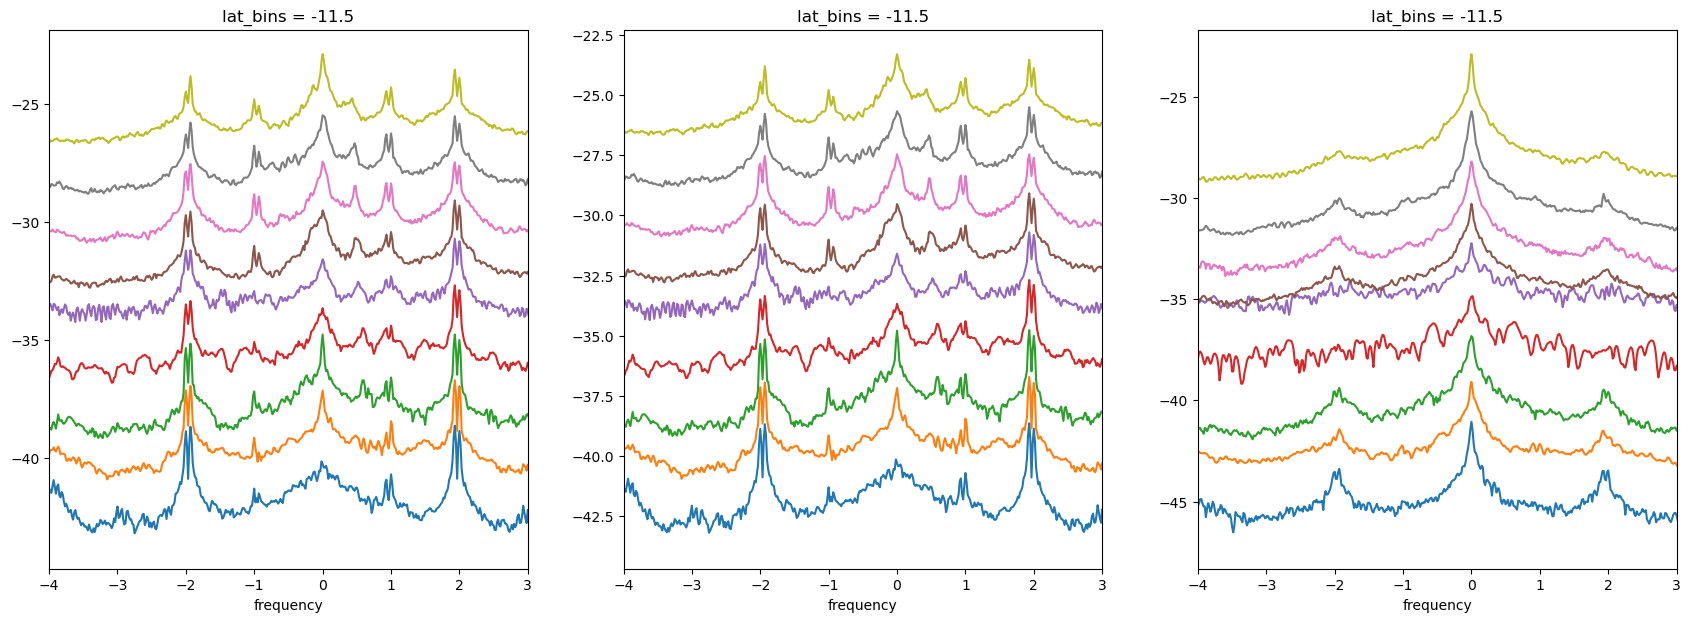

In [67]:
fig, axs = plt.subplots(1,len(ds_NWA.keys()),figsize=(len(ds_NWA.keys())*7,7))
for V,ax in zip(ds_NWA.keys(),axs):
    for i in ds_NWA.lat_bins:
        (np.log10(ds_NWA[V].sel(lat_bins=i))+2*i).plot(ax=ax)
        ax.set_xlim(-4,3)

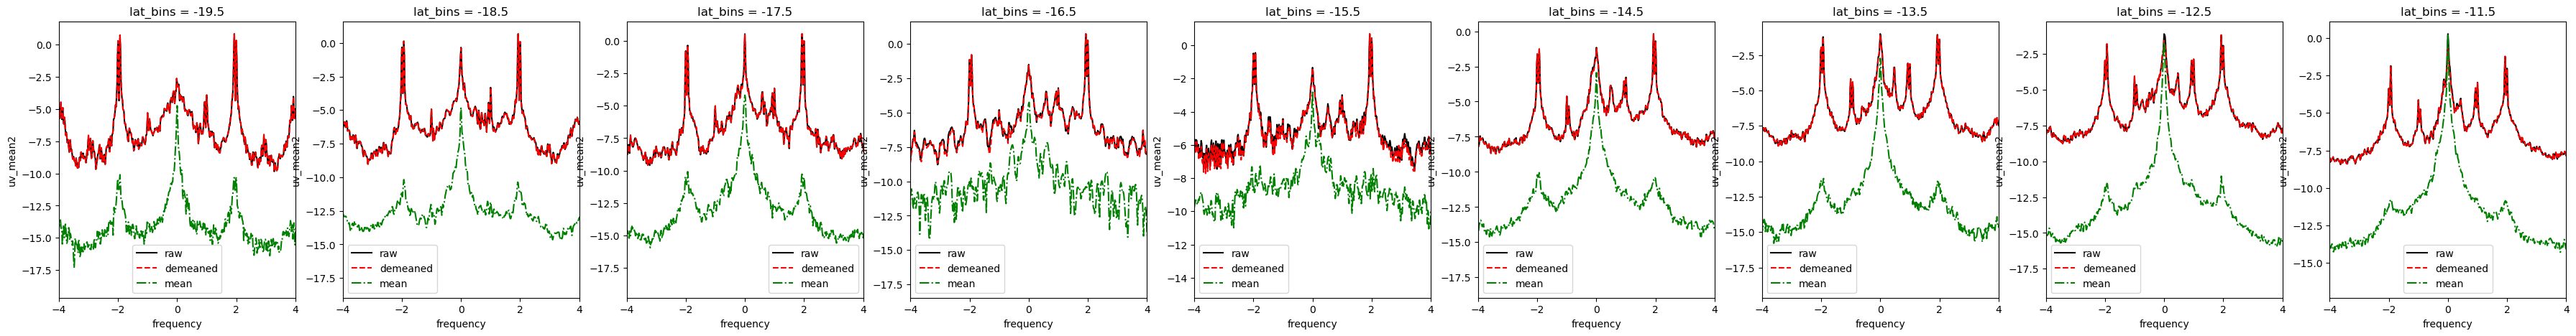

In [68]:
labels = ['raw', 'demeaned','mean']
fig,axs = plt.subplots(1,len(ds_NWA.lat_bins.values),figsize=(len(ds_NWA.lat_bins.values)*5,5))
for V,c,style in zip(ds_NWA.keys(),colors,styles):
    for i,ax in enumerate(axs):
    
        np.log(ds_NWA[V].isel(lat_bins=i)).plot(c=c,linestyle=style,ax=ax
                                           )
        ax.set_xlim(-4,4)
        ax.legend(labels)

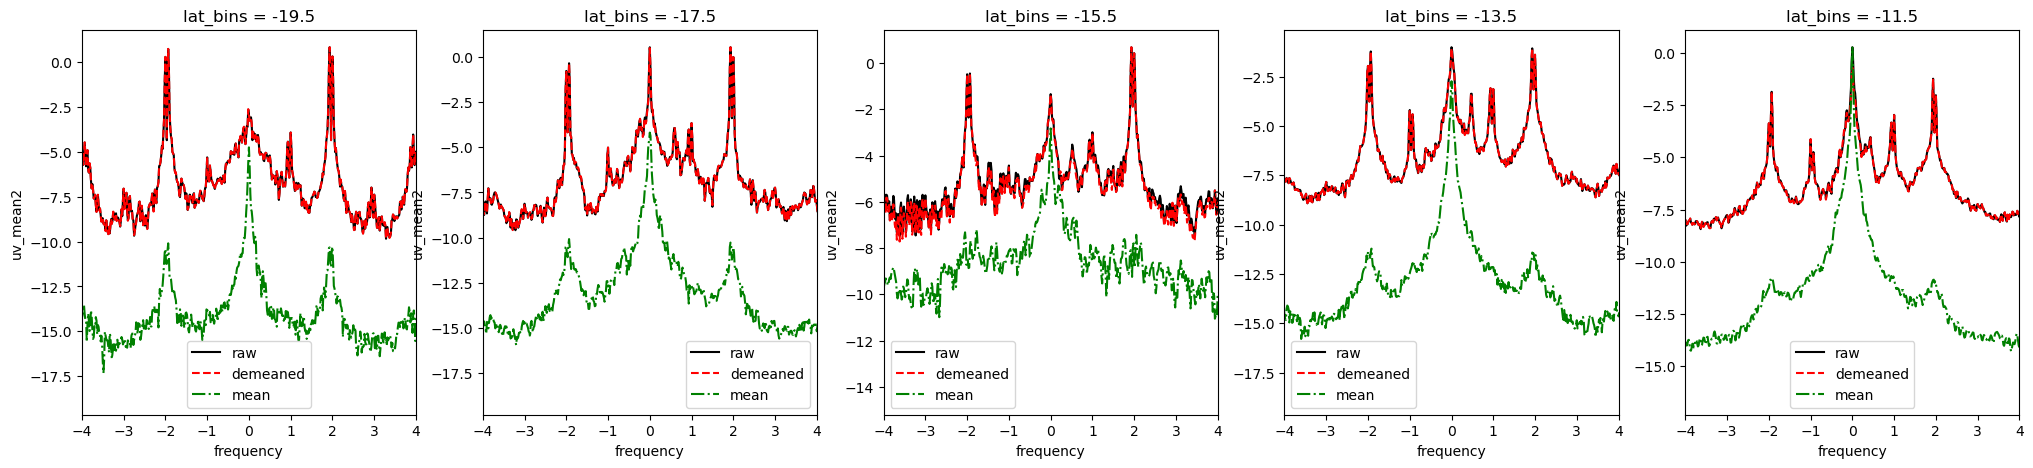

In [69]:
labels = ['raw', 'demeaned','mean']
fig,axs = plt.subplots(1,len(ds_NWA.lat_bins.values[::2]),figsize=(len(ds_NWA.lat_bins.values[::2])*5,5))
for V,c,style in zip(ds_NWA.keys(),colors,styles):
    for l,ax in zip(ds_NWA.lat_bins.values[::2],axs):
    
        np.log(ds_NWA[V].sel(lat_bins=l)).plot(c=c,linestyle=style,ax=ax
                                           )
        ax.set_xlim(-4,4)
        ax.legend(labels)

(-5.0, 5.0)

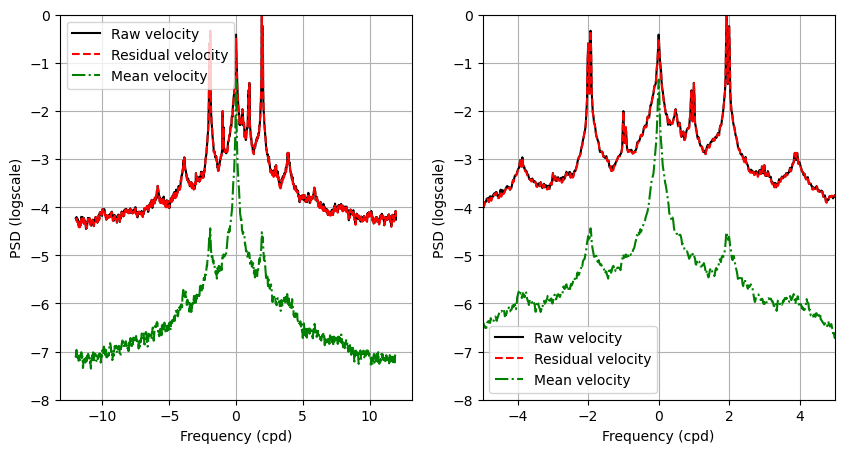

In [21]:
colors=['k','r','g']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
for V,c,style in zip(ds_NWA.keys(),colors,styles):
    np.log10(ds_NWA[V]).mean(['lat_bins']).plot(ax=ax[0],c=c,linestyle=style)
    np.log10(ds_NWA[V]).mean(['lat_bins']).plot(ax=ax[1],c=c,linestyle=style)
for a in ax:
    a.grid();a.set_ylim(-8,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)
ax[1].set_xlim(-5,5)

In [73]:
dsE_NWA = dsE_NWA.compute()

In [76]:
dsE_NWA

<xarray.DataArray 'E_SSUV' (frequency: 1440, lat_bins: 9)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins   (lat_bins) float64 -19.5 -18.5 -17.5 -16.5 ... -13.5 -12.5 -11.5

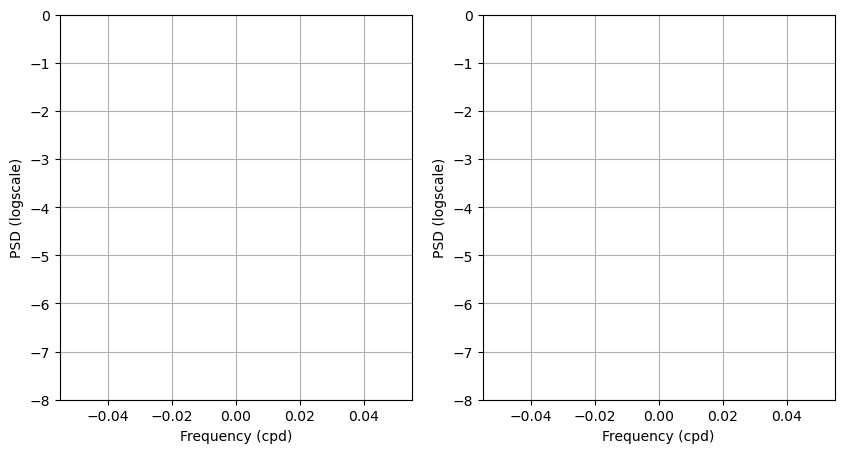

In [75]:
colors=['k','r','g']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
#for V,c,style in zip(dsE_Cal.keys(),colors,styles):
np.log10(dsE_NWA).mean(['lat_bins']).plot(ax=ax[0],c=colors[0],linestyle=styles[0])
np.log10(dsE_NWA).mean(['lat_bins']).plot(ax=ax[1],c=colors[0],linestyle=styles[0])
for a in ax:
    a.grid();a.set_ylim(-8,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');


(-5.0, 5.0)

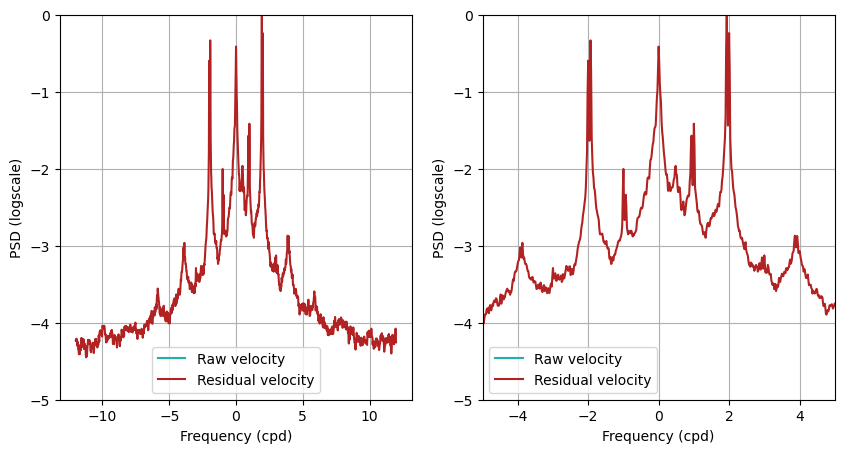

In [70]:
#colors=['k','r','g']
colors=['lightseagreen','firebrick']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
#for V,c,style in zip(dsE_Cal.keys(),colors,styles):
np.log10(dsE_NWA).mean(['lat_bins']).plot(ax=ax[0],c=colors[0],linestyle=styles[0])
np.log10(dsE_NWA).mean(['lat_bins']).plot(ax=ax[1],c=colors[0],linestyle=styles[0])
np.log10(ds_NWA['uv']).mean(['lat_bins']).plot(ax=ax[0],c=colors[1],linestyle=styles[0])
np.log10(ds_NWA['uv']).mean(['lat_bins']).plot(ax=ax[1],c=colors[1],linestyle=styles[0])
for a in ax:
    a.grid();a.set_ylim(-5,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)
ax[1].set_xlim(-5,5)

In [77]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
